In [31]:
import numpy as np
import pandas as pd
import sqlite3
import datetime
from matplotlib import pyplot as plt

from spacy.lang.en import English
nlp = English()
# Create a Tokenizer with the default settings for English
# including punctuation rules and exceptions
tokenizer = nlp.tokenizer

# num_tok = len(tokenizer(my_string))

In [3]:
suff = '5feb2021'
dbname = 'data/session_info_feb5.db'

workbookname = 'data/sona_convos_annotated_%s.xlsx' % suff
surveyfilename = 'data/Questions_baseline_chatbot_February 5, 2021_16.06.csv'

In [4]:
cur = sqlite3.connect(dbname).cursor()

In [107]:
# load survey data sheet
raw_survey_df = pd.read_csv(surveyfilename)
survey_question_text_ts = raw_survey_df.loc[0]
raw_survey_df[:5]

,StartDate,EndDate,Status,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,DistributionChannel,UserLanguage,...,Q255_2,Q255_3,Q255_4,Q255_5,Q255_6,Q58,Q57,SC0,SC2,id
0,Start Date,End Date,Response Type,Progress,Duration (in seconds),Finished,Recorded Date,Response ID,Distribution Channel,User Language,...,Please indicate the degree to which you agree ...,Please indicate the degree to which you agree ...,Please indicate the degree to which you agree ...,Please indicate the degree to which you agree ...,Please indicate the degree to which you agree ...,If at any point you wanted to leave the conver...,Thank you for participating in our study. If y...,Score,PHQ-8 Patient Health Questionnaire- 8items,id
1,"{""ImportId"":""startDate"",""timeZone"":""America/De...","{""ImportId"":""endDate"",""timeZone"":""America/Denv...","{""ImportId"":""status""}","{""ImportId"":""progress""}","{""ImportId"":""duration""}","{""ImportId"":""finished""}","{""ImportId"":""recordedDate"",""timeZone"":""America...","{""ImportId"":""_recordId""}","{""ImportId"":""distributionChannel""}","{""ImportId"":""userLanguage""}",...,"{""ImportId"":""QID311_2""}","{""ImportId"":""QID311_3""}","{""ImportId"":""QID311_4""}","{""ImportId"":""QID311_12""}","{""ImportId"":""QID311_13""}","{""ImportId"":""QID321_TEXT""}","{""ImportId"":""QID320_TEXT""}","{""ImportId"":""SC_by0GhYnW8z2dcq1""}","{""ImportId"":""SC_6gkccQmPIhIRJM9""}","{""ImportId"":""id""}"
2,2020-11-06 00:40:59,2020-11-06 00:45:57,Survey Preview,100,298,True,2020-11-06 00:45:58,R_1rAOxkXtOyiprCR,preview,EN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,6,NaN
3,2020-11-06 01:05:24,2020-11-06 01:08:11,Survey Preview,100,167,True,2020-11-06 01:08:13,R_O2mBVurRhoHtoHv,preview,EN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20,17,NaN
4,2020-12-01 12:15:36,2020-12-01 12:15:36,Survey Test,100,0,True,2020-12-01 12:15:36,R_d1rrLLibNXatf6J,test,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,15,NaN


In [6]:
# load conversation sheets
convos = pd.read_excel(workbookname, engine='openpyxl', sheet_name=None)
convo_ids = list(convos.keys())

In [7]:
print('Example convo ids: ', convo_ids[:5])
convos[convo_ids[10]][:5]

Example convo ids:  ['9244_22cee091', '50081_a05ac73b', '50321_27d7083e', '38917_bca8e1ae', '46238_3e041c3a']


,Flow Index,User Message,Bot Response,helpful,error,why_leave
0,0,START,"Hi, it’s great to meet you!",1.0,NaN,na
1,1,How are you?,How are you doing?,NaN,1.0,na
2,2,I am alright. Feeling a little down :(,I've heard that many people stay at home more ...,1.0,NaN,na
3,3,Yes,I see. I've also heard that many people's diet...,1.0,NaN,na
4,4,I don't think so,Ok. These last few months have been really dif...,1.0,NaN,na


### Calculate statistics on conversations & annotations

In [8]:
convo_stats = [] # these are statistics on each participant's converstion 
# flow_stats = [] # these are statistics on each flow message


for cid in convo_ids: 
    
    sona, sid = cid.split('_')
    
    
    if len(sona) != 5:
        print('Admin testing system, omitting: ', cid)
        # Not a valid SONA (5 digit intiger), likely admin testing sona 9244
        continue
        
    if sona in ['38917', '46238', '50321', '50081']:
        print('Was in pilot, omitting: ', cid)
        # This was a pilot conversation before we changed the binary "want to leave" to multiple choice "why leave" question
        continue
        
        
    results = cur.execute('select sid, joined_time from session_meta_data where pid=="%s"' % sona).fetchall()
    [convo_joined_time,] = [int(x[1]) for x in results if x[0].startswith(sid)]
    
    convo = convos[cid]
    num_messages = convo.shape[0]
    
    # Counts of likes, errors, leave
    num_helpful = convo['helpful'].sum()
    num_error = convo['error'].sum()
    num_leave = (convo['why_leave'].dropna() != 'na').sum()
    
    # When first leave? 
    want_to_leave = convo['why_leave'].dropna() != 'na'
    first_leave = convo['why_leave'].dropna()[want_to_leave].index.min()
    
    # Why first leave?
    why_first_leave = convo['why_leave'][first_leave] if first_leave is not np.nan else 'complete_convo'
    
    # Error to leave? How long after the first error did they want to leave?
    first_error = convo['error'].dropna().index.min()
    error_to_leave = first_leave - first_error
    error_before_leave = first_error < first_leave
    error_is_leave = first_error == first_leave
    
    # participant engagement: how much participant wrote in conversation
    message_tok = [len(tokenizer(x)) if x is not np.nan else 0 for x in convo['User Message'][1:].values]
    avg_message_tok = np.mean(message_tok)
    tot_message_tok = np.sum(message_tok)
    
    
    
    convo_stats.append([cid, sona, sid, datetime.datetime.fromtimestamp(convo_joined_time), 
                        num_messages, num_helpful, num_error, num_leave, 
                        first_leave, why_first_leave, first_error, error_to_leave, 
                        error_before_leave, error_is_leave,
                        avg_message_tok, tot_message_tok])
    
#     What kinds of messages did people dis/like
#     Is the effect of errors worse for people who are more depressed/anxious?
#     Was the bot more likely to make mistakes on certain messages?
#     Were mistakes more common for certain message types? Were certain types more helpful?
#     Did certain people like/prefer certain types of messages? E.g., depressed people prefer chatting to tips
#     Length of response to flow message

convo_stats_df = pd.DataFrame(convo_stats, columns = ['cid', 'sona', 'session_id', 'convo_joined_datetime', 
                                                      'num_messages', 'num_helpful', 'num_error', 'num_leave', 
                                                     'first_leave', 'why_first_leave', 'first_error', 'error_to_leave', 
                                                      'error_before_leave', 'error_is_leave', 
                                                      'avg_message_tok', 'tot_message_tok'])

Admin testing system, omitting:  9244_22cee091
Was in pilot, omitting:  50081_a05ac73b
Was in pilot, omitting:  50321_27d7083e
Was in pilot, omitting:  38917_bca8e1ae
Was in pilot, omitting:  46238_3e041c3a


In [9]:
print('DF dimensions: ', convo_stats_df.shape)
convo_stats_df[:5]

DF dimensions:  (133, 16)


,cid,sona,session_id,convo_joined_datetime,num_messages,num_helpful,num_error,num_leave,first_leave,why_first_leave,first_error,error_to_leave,error_before_leave,error_is_leave,avg_message_tok,tot_message_tok
0,50375_82125de0,50375,82125de0,2021-01-27 09:44:29,29,0.0,4.0,0,NaN,complete_convo,13.0,NaN,False,False,3.928571,110
1,45644_643fcbec,45644,643fcbec,2021-01-27 10:16:35,19,5.0,2.0,1,18.0,nofeedback,10.0,8.0,True,False,22.611111,407
2,41923_87b34bf0,41923,87b34bf0,2021-01-27 10:47:48,29,16.0,10.0,6,4.0,nolisten,4.0,0.0,False,True,3.428571,96
3,51190_8d0fe287,51190,8d0fe287,2021-01-27 11:07:59,29,28.0,1.0,6,2.0,nocare,7.0,-5.0,False,False,8.035714,225
4,44598_937c2601,44598,937c2601,2021-01-27 11:06:01,28,5.0,0.0,0,NaN,complete_convo,NaN,NaN,False,False,13.148148,355


### Add a datetime column to survey responses so response time can be compared with conversation time

In [108]:
for i in raw_survey_df.index:
    try:
        raw_survey_df.loc[i, 'EndDate_datetime'] = datetime.datetime.strptime(raw_survey_df.loc[i, 'EndDate'], '%Y-%m-%d %H:%M:%S')
    except:
        pass

### Drop duplicate annotated conversations and survey responses for participants
Make sure to end up with one annotated convo and one survey response for each participant

if two conversations are annotated, drop the one that happened later in time


if two survey responses:

    * if one is 'Finished', drop the other
    * else take the one closer in time to the conversation

In [120]:
survey_df = raw_survey_df.copy()

print('Start convo dim:', convo_stats_df.shape)
print('Start survey dim:', survey_df.shape)

for sona in convo_stats_df['sona'].unique():
    s = survey_df[survey_df['id'] == sona]
    a = convo_stats_df[convo_stats_df['sona'] == sona]
    
    # If more than two annotated conversations, drop later one
    if a.shape[0] > 1: 
        # index of last conversation: 
        dropidx = a['convo_joined_datetime'].idxmax()
        
        print('Dropping extra annoated convo for sona ', sona)
        convo_stats_df.drop(index=dropidx, inplace=True)
        
        
    if s.shape[0] > 1: 
        if sum(s['Finished'] == 'True') == 1:
            
            # index of the non-finished survey response
            dropidx = s[s['Finished'] == 'False'].index
            reason = 'unfinished'
        else:
            
            # list of indices for survey rows for participant
            idxs = s.index

            # calculate absolute time distance of survey response to conversation
            time_dists = [abs((x - a['convo_joined_datetime'].values[0]).total_seconds()) for x in s['EndDate_datetime']]
            
            # rows to drop from survey dataframe are those NOT closest to annotations
            dropidx = idxs[time_dists != np.min(time_dists)]
            reason = 'less close in time'
        
        print('Dropping extra survey response for sona %s because %s' % (sona, reason))
        survey_df.drop(index=dropidx, inplace=True)
        
print('End convo dim:', convo_stats_df.shape)
print('End survey dim:', survey_df.shape)


Start convo dim: (132, 16)
Start survey dim: (215, 78)
Dropping extra survey response for sona 44692 because less close in time
Dropping extra survey response for sona 51389 because unfinished
Dropping extra survey response for sona 50638 because less close in time
Dropping extra survey response for sona 48240 because unfinished
Dropping extra survey response for sona 45566 because unfinished
Dropping extra survey response for sona 48169 because unfinished
Dropping extra survey response for sona 46440 because unfinished
Dropping extra survey response for sona 48039 because less close in time
Dropping extra survey response for sona 47727 because unfinished
Dropping extra survey response for sona 44600 because unfinished
Dropping extra survey response for sona 50082 because unfinished
Dropping extra survey response for sona 45849 because unfinished
Dropping extra survey response for sona 49423 because less close in time
Dropping extra survey response for sona 41060 because unfinished
Dro

## Aggregate survey and conversation records

In [121]:
participant_df = survey_df.merge(convo_stats_df, left_on='id', right_on='sona', how='right')
participant_df.shape

(132, 94)

In [ ]:
# Uncomment to print column names & question text, if desired:

# for i in participant_df.columns:
#     if i in survey_question_text_ts.index:
#         print('%s\t%s' % (i, survey_question_text_ts[i].replace('\n', ' ')))
#     else:
#         print('%s\t%s' % (i,i))

### Rename columns and convert types

In [127]:
# 'Q249_1': mood before chat?
# 'Q55_1': mood after chat?

for col in ['SC0', 'SC2', 'Q249_1','Q55_1']:
    participant_df[col] = participant_df[col].astype(float)
    
    
participant_df['phq8'] = participant_df['SC2']

participant_df['mood_before'] = participant_df['Q249_1']
participant_df['mood_after'] = participant_df['Q55_1']
participant_df['mood_change'] = participant_df['mood_after'] - participant_df['mood_before']


# Q242: Have you ever chatted with a chatbot?
# Q251: Have you ever used a chatbot for mental health?
# Q219: how hard to imagine mood?
participant_df['chatbot_experience'] = participant_df['Q242'] == 'Yes'
participant_df['chatbot_mh_experience'] = participant_df['Q251'] == 'Yes'
participant_df['cant_imagine_mood'] = participant_df['Q219'] == 'Not at all'


# Preliminary exploratory plots

## How bad were people feeling to start off?

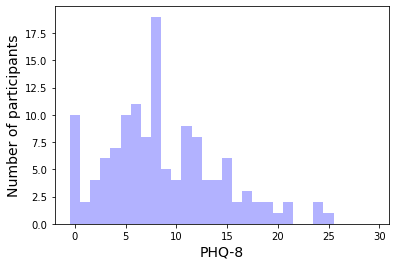

In [86]:
plt.hist(participant_df['phq8'], bins=np.arange(-.5,30.5), alpha=.3, color='b', label='phq8 at start')
plt.ylabel('Number of participants', fontsize=14)
plt.xlabel('PHQ-8', fontsize=14)
plt.show()

## How did mood score before chat relate to phq8?

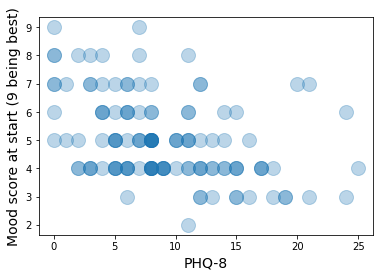

In [87]:
plt.plot(participant_df['phq8'], participant_df['mood_before'], 'o', alpha=.3, markersize=14)
plt.ylabel('Mood score at start (9 being best)', fontsize=14)
plt.xlabel('PHQ-8', fontsize=14)
plt.show()

## Did chatting with the bot provide any relief?

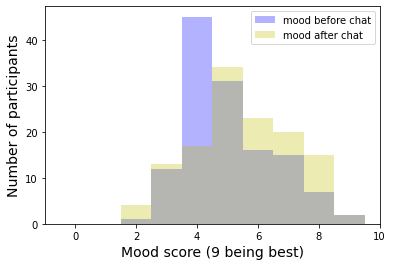

In [84]:

plt.hist(participant_df['mood_before'], bins=np.arange(-.5,10.5), alpha=.3, color='b', label='mood before chat')
plt.hist(participant_df['mood_after'], bins=np.arange(-.5,10.5), alpha=.3, color='y', label='mood after chat')
plt.ylabel('Number of participants', fontsize=14)
plt.xlabel('Mood score (9 being best)', fontsize=14)
plt.legend()
plt.show()



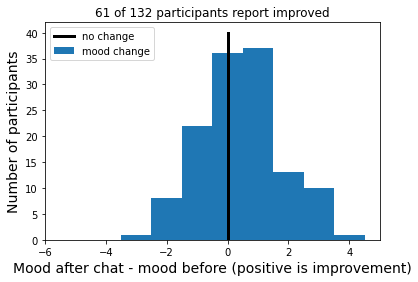

In [73]:
plt.hist(participant_df['mood_change'], bins=np.arange(-5.5,5.5), label='mood change')
plt.plot([0,0],[0,40], 'k', linewidth=3, label='no change')
plt.ylabel('Number of participants', fontsize=14)
plt.xlabel('Mood after chat - mood before (positive is improvement)', fontsize=14)
plt.title('%s of %s participants report improved' % (sum(participant_df['mood_change']>0), participant_df.shape[0]))
plt.legend()
plt.show()


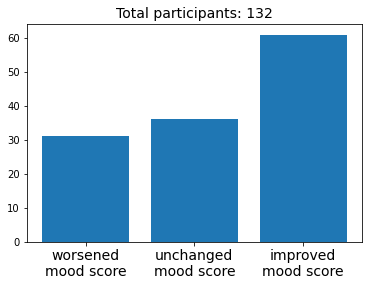

In [85]:
improved = sum(participant_df['mood_change'] > 0)
unchanged = sum(participant_df['mood_change'] == 0)
worsened = sum(participant_df['mood_change'] < 0)

temp = [worsened, unchanged, improved]
temp_ticks = ['worsened\nmood score', 'unchanged\nmood score', 'improved\nmood score']

plt.bar(range(len(temp)), temp)
plt.xticks(range(len(temp)), temp_ticks, fontsize=14)
plt.title('Total participants: %s' % participant_df.shape[0], fontsize=14)
plt.show()

### Was change in mood related to mood at start?

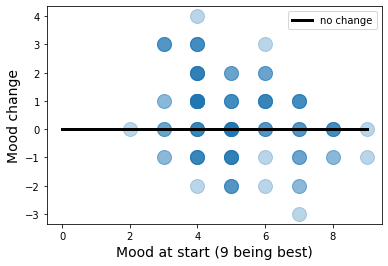

In [90]:
plt.plot(participant_df['mood_before'], participant_df['mood_change'], 'o', alpha=.3, markersize=14)
plt.plot([0, 9],[0, 0], 'k', linewidth=3, label='no change')
plt.ylabel('Mood change', fontsize=14)
plt.xlabel('Mood at start (9 being best)', fontsize=14)
plt.legend()
plt.show()

## Do people who are more familiar with chatbots experience more relief/benefit?

* Q242: Have you ever chatted with a chatbot? ['Yes' 'No' "I don't know" nan] 'chatbot_experience'
* Q251: Have you ever used a chatbot for mental health? ['Yes' 'No' "I don't know" nan] 'chatbot_mh_experience'
* Q219: how hard to imagine mood? ['Yes' 'No' "I don't know" nan] 'cant_imagine_mood'

In [137]:
print('Used chatbot for mental health: ', sum(participant_df['chatbot_mh_experience']))
print('Cannot imagine a bad mood: ', sum(participant_df['cant_imagine_mood']))

Used chatbot for mental health:  6
Cannot imagine a bad mood:  2


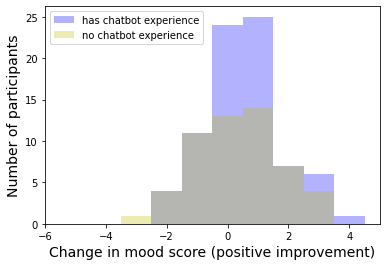

In [138]:
ind = participant_df['chatbot_experience'] 
plt.hist(participant_df[ind]['mood_change'], bins=np.arange(-5.5,5.5), alpha=.3, color='b', label='has chatbot experience')
plt.hist(participant_df[~ind]['mood_change'], bins=np.arange(-5.5,5.5), alpha=.3, color='y', label='no chatbot experience')
plt.ylabel('Number of participants', fontsize=14)
plt.xlabel('Change in mood score (positive improvement)', fontsize=14)
plt.legend()
plt.show()

## How long were participant messages?

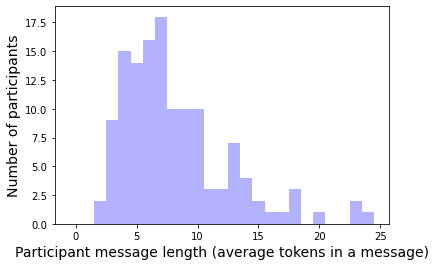

In [184]:
plt.hist(participant_df['avg_message_tok'], bins=np.arange(-.5, 25.5), alpha=.3, color='b')
plt.ylabel('Number of participants', fontsize=14)
plt.xlabel('Participant message length (average tokens in a message)', fontsize=14)
# plt.legend()
plt.show()

## Annotation overview

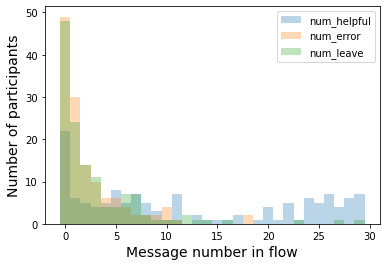

In [185]:
for col in ['num_helpful', 'num_error', 'num_leave']:
    plt.hist(participant_df[col], bins=np.arange(-.5,30.5), alpha=.3, label=col)

plt.ylabel('Number of participants', fontsize=14)
plt.xlabel('Message number in flow', fontsize=14)
plt.legend()
plt.show()

## When did people first want to leave the conversation

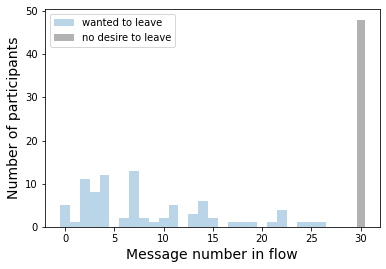

In [179]:
plt.hist(participant_df['first_leave'], bins=np.arange(-.5,30.5), alpha=.3, label='wanted to leave')
plt.bar([30], [np.isnan(participant_df['first_leave'].values).sum()], alpha=.3, color='k', label='no desire to leave')
plt.ylabel('Number of participants', fontsize=14)
plt.xlabel('Message number in flow', fontsize=14)
plt.legend()
plt.show()

In [178]:
a = sum(participant_df['first_leave'] <= 5)
b = participant_df.shape[0]
c = sum(np.isnan(participant_df['first_leave']))
print('Leave within first 5 messages: %s of %s (%.2f%%)' % (a, b, 100.*float(a)/b))
print('Never leave: %s of %s (%.2f%%)' % (c, b, 100.*float(c)/b))

Leave within first 5 messages: 37 of 132 (28.03%)
Never leave: 48 of 132 (36.36%)


## How long after the first error did individuals want to leave?

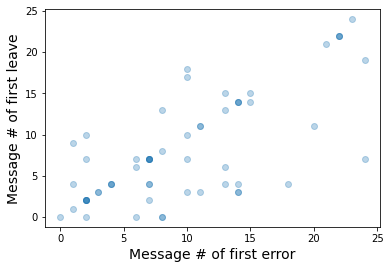

In [155]:
plt.plot(participant_df['first_error'], participant_df['first_leave'], 'o', alpha=.3)
plt.ylabel('Message # of first leave', fontsize=14)
plt.xlabel('Message # of first error', fontsize=14)
plt.show()

## What is the first reason to leave?

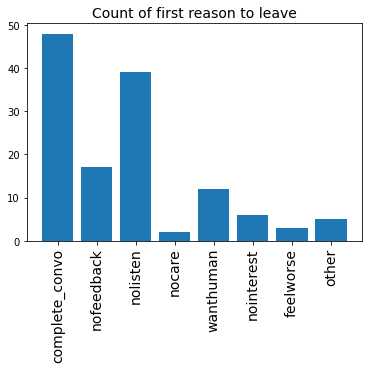

In [170]:
from collections import Counter
c = Counter(participant_df['why_first_leave'])
reasons = [x[0] for x in c.items()]
counts = [x[1] for x in c.items()]

plt.bar(range(len(reasons)), counts)
plt.xticks(range(len(reasons)), reasons, fontsize=14, rotation=90)
plt.title('Count of first reason to leave', fontsize=14)
plt.show()


## Do people who write more report mood improvement?

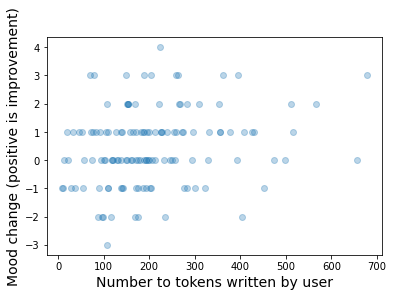

In [171]:
plt.plot(participant_df['tot_message_tok'], participant_df['mood_change'], 'o', alpha=.3)
plt.ylabel('Mood change (positive is improvement)', fontsize=14)
plt.xlabel('Number to tokens written by user', fontsize=14)
plt.show()

# Write to CSV

In [186]:
participant_df.to_csv('data/participant_data_18feb2021.csv')